# Meshes

This guide demonstrates the use of meshes in **continuiti**.

In this example, we will load a `Gmsh` file and train a physics-informed neural
operator.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import pathlib
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from continuiti.data import OperatorDataset
from continuiti.data.mesh import Gmsh
from continuiti.operators import DeepONet
from continuiti.trainer import Trainer
from continuiti.pde import div, grad, PhysicsInformedLoss

In [3]:
torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

In [4]:
# Generate the mesh
import os
meshes_dir = pathlib.Path.cwd().joinpath("..", "data", "meshes")
geofile = meshes_dir.joinpath("mediterranean.geo").as_posix()
os.system(f"gmsh -2 {geofile}")

Info    : Running '/Users/samuelburbulla/code/continuiti/venv/bin/gmsh -2 /Users/samuelburbulla/code/continuiti/examples/../data/meshes/mediterranean.geo' [Gmsh 4.12.2, 1 node, max. 1 thread]
Info    : Started on Mon Aug 19 12:07:12 2024
Info    : Reading '/Users/samuelburbulla/code/continuiti/examples/../data/meshes/mediterranean.geo'...
Info    : Done reading '/Users/samuelburbulla/code/continuiti/examples/../data/meshes/mediterranean.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 2 (Nurb)


Info    : [ 10%] Meshing curve 3 (Nurb)
Info    : [ 10%] Meshing curve 4 (Nurb)
Info    : [ 10%] Meshing curve 8 (Nurb)
Info    : [ 10%] Meshing curve 9 (Nurb)
Info    : [ 10%] Meshing curve 10 (Nurb)
Info    : [ 10%] Meshing curve 11 (Nurb)
Info    : [ 10%] Meshing curve 12 (Nurb)
Info    : [ 10%] Meshing curve 13 (Nurb)
Info    : [ 10%] Meshing curve 14 (Nurb)
Info    : [ 10%] Meshing curve 15 (Nurb)
Info    : [ 10%] Meshing curve 16 (Nurb)
Info    : [ 10%] Meshing curve 17 (Nurb)
Info    : [ 10%] Meshing curve 18 (Nurb)
Info    : [ 10%] Meshing curve 19 (Nurb)
Info    : [ 10%] Meshing curve 20 (Nurb)
Info    : [ 10%] Meshing curve 21 (Nurb)
Info    : [ 10%] Meshing curve 23 (Nurb)
Info    : [ 10%] Meshing curve 24 (Nurb)
Info    : [ 10%] Meshing curve 25 (Nurb)
Info    : [ 10%] Meshing curve 26 (Nurb)
Info    : [ 10%] Meshing curve 27 (Nurb)
Info    : [ 10%] Meshing curve 28 (Nurb)
Info    : [ 10%] Meshing curve 29 (Nurb)
Info    : [ 10%] Meshing curve 30 (Nurb)
Info    : [ 10%] Mes

Info    : [ 20%] Meshing curve 53 (Nurb)
Info    : [ 20%] Meshing curve 54 (Nurb)
Info    : [ 20%] Meshing curve 55 (Nurb)
Info    : [ 20%] Meshing curve 56 (Nurb)
Info    : [ 20%] Meshing curve 57 (Nurb)
Info    : [ 20%] Meshing curve 58 (Nurb)
Info    : [ 20%] Meshing curve 59 (Nurb)
Info    : [ 20%] Meshing curve 60 (Nurb)
Info    : [ 20%] Meshing curve 61 (Nurb)
Info    : [ 20%] Meshing curve 62 (Nurb)
Info    : [ 20%] Meshing curve 63 (Nurb)
Info    : [ 20%] Meshing curve 64 (Nurb)
Info    : [ 20%] Meshing curve 65 (Nurb)
Info    : [ 20%] Meshing curve 66 (Nurb)
Info    : [ 20%] Meshing curve 67 (Nurb)
Info    : [ 20%] Meshing curve 68 (Nurb)
Info    : [ 20%] Meshing curve 69 (Nurb)
Info    : [ 20%] Meshing curve 70 (Nurb)
Info    : [ 20%] Meshing curve 71 (Nurb)
Info    : [ 20%] Meshing curve 72 (Nurb)
Info    : [ 20%] Meshing curve 73 (Nurb)
Info    : [ 20%] Meshing curve 74 (Nurb)
Info    : [ 20%] Meshing curve 75 (Nurb)
Info    : [ 20%] Meshing curve 76 (Nurb)
Info    : [ 20%]

0

We use the `Gmsh` class to read a mesh from a file generated by Gmsh.

In [5]:
meshes_dir = pathlib.Path.cwd().joinpath("..", "data", "meshes")
gmsh_file = meshes_dir.joinpath("mediterranean.msh").as_posix()

mesh = Gmsh(gmsh_file)
vertices = mesh.get_vertices()

# We use longitude and latitude only and scale them to be in the range [-1, 1]
vertices = vertices[1:, :]
vertices -= vertices.mean(dim=1, keepdim=True)
vertices /= vertices[0, :].abs().max()

In [6]:
meshes_dir = pathlib.Path.cwd().joinpath("..", "data", "meshes")
gmsh_file = meshes_dir.joinpath("mediterranean.msh")

if not gmsh_file.is_file():
    vertices = torch.rand(2, 100)

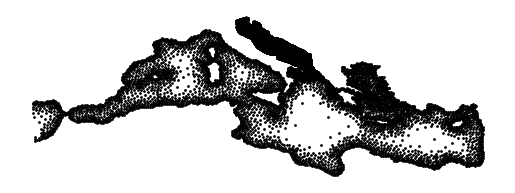

In [7]:
plt.scatter(vertices[0], vertices[1], 1, c="black")
plt.gca().axis("off")
plt.gca().set_aspect("equal")

## Problem Statement

Let's assume we have a set of temperature measurements and want to 
reconstruct a physically meaningful temperature distribution in the
whole mediterranean sea. We define a data set by generating random sensor
inputs and plot the first entry.

In [8]:
num_observation = 1
num_sensors = 5

x = torch.zeros(num_observation, 2, num_sensors)
u = torch.zeros(num_observation, 1, num_sensors)
y = torch.zeros(num_observation, 2, num_sensors)
v = torch.zeros(num_observation, 1, num_sensors)

for i in range(num_observation):

    # Select random sensor positions
    idx = torch.randperm(vertices.shape[1])[:num_sensors]
    x[i] = vertices[:, idx]

    # Generate random sensor measurements
    u[i] = torch.rand(1, num_sensors)
    
    # The mapped function equals u the sensors
    # (but we will add a physics-informed loss later w.r.t to all vertices)
    y[i] = x[i]
    v[i] = u[i]

dataset = OperatorDataset(x, u, y, v)

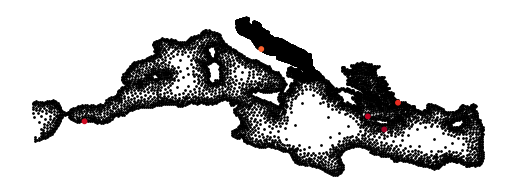

In [9]:
# Get a first observation from training set
u0 = torch.rand(num_sensors, 1)
x0, u0, _, _ = dataset[0]

# Plot
plt.scatter(vertices[0], vertices[1], 1, c="black")
plt.scatter(x0[0], x0[1], 10, u0, cmap="YlOrRd", vmin=-1, vmax=1)
plt.gca().axis("off")
plt.gca().set_aspect("equal")

## Neural Operator

In this example, we use a DeepONet architecture.

In [10]:
operator = DeepONet(dataset.shapes)

## Physics-informed loss

As we want to learn a physically meaningful completion, we define a
physics-informed loss function satisfying:

$$- \Delta v = 0$$

In [11]:
y_physics = vertices.clone().requires_grad_(True)[:, ::100] # Use a subset of vertices for the physics-informed loss
mse = torch.nn.MSELoss()

def pde(x, u, y, v):
    # Sensor measurements
    loss = mse(v, u)

    # Physics-informed loss w.r.t. all vertices
    w = lambda y: operator(x, u, y)
    Delta = div(grad(w))

    y_all = y_physics.repeat(u.shape[0], 1, 1).to(y.device)
    loss += (Delta(y_all)**2).mean()

    return loss

loss_fn = PhysicsInformedLoss(pde)

## Training

We train the neural operator using the physics-informed loss function. 

In [12]:
Trainer(operator, loss_fn=loss_fn).fit(dataset, tol=1e-2, epochs=10000)

Parameters: 5296  Device: mps
Epoch 3582/10000  Step  1/1  [====================]  39ms/step  [2:17min<4:07min] - loss/train = 9.9979e-03  - stopping criterion met



Logs(epoch=3582, step=1, loss_train=0.009997924789786339, loss_test=None)

## Evaluation

Let's evaluate the trained operator on our initial sensor measurements
and compute a test error.

In [13]:
x_test = x0.unsqueeze(0)
u_test = u0.unsqueeze(0)

test_loss = mse(operator(x_test, u_test, x_test), u_test)
print(f"loss/test = {test_loss.item():.4e}")


loss/test = 8.9705e-03


## Plotting
We can plot the mapped function on the whole mesh by using the cell 
information from the mesh file and pass it as `Triangulation` to matplotlib.

In [14]:
tri = Triangulation(vertices[0], vertices[1], mesh.get_cells())

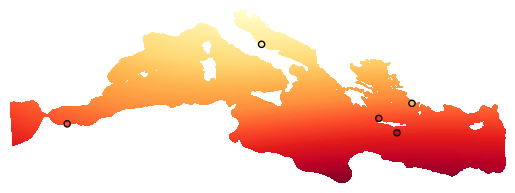

In [15]:
# Plot with contours
y_plot = vertices.unsqueeze(0)
v_plot = operator(x_test, u_test, y_plot).detach().squeeze()

# Triangulation
kwargs = {"vmin": v_plot.min(), "vmax": v_plot.max(), "cmap": "YlOrRd"}
cb = plt.tricontourf(tri, v_plot, levels=100, **kwargs)

# Add sensors
plt.scatter(x0[0], x0[1], 20, u0, edgecolors="k", **kwargs)

plt.gca().axis("off")
plt.gca().set_aspect("equal")